In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os
from netCDF4 import Dataset 

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [13]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## Functions

In [14]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

In [15]:
#Calculate the analytically determined surface normal as a function of x and y
def calc_ref_normal_2D(x,y,geometry):
    if geometry == "circle":
        n_x = x/np.sqrt(x**2+y**2)
        n_y = y/np.sqrt(x**2+y**2)
    if geometry == "sine":
        n_x = -np.cos(x)/np.sqrt(np.cos(x)**2+1)
        n_y = 1/np.sqrt(np.cos(x)**2+1)
    
    return np.array([n_x, n_y])

In [16]:
#Extract data for the surface normal from LAMMPS simulation
def calc_data_normal_2D(ds, geometry):
    atom_values = {}
    frame = -1
    atom_ids = (ds["id"][frame])
    for atom in atom_ids:
        if geometry == "circle":
            if ds["c_surf"][frame][atom-1] == 2.: 
                coords = (ds["coordinates"][frame,atom-1,0:2]) #coords
                x = coords[0]
                y = coords[1]

                n_x, n_y = (ds["f_2"][frame,atom-1,:])

                atom_values[(x,y)] = np.array([n_x,n_y])

    return atom_values

In [17]:
#Benchmark by plotting kinetic energy decay and viscosity
def benchmark(data_files, geometry):
    
    fig, ax = plt.subplots(1,1)
    all_run_info = []

    for run in data_files:
        #Read the filepath and create a dataset
        run_info = list(run)[0:2]
        ds = Dataset(data_files[run])
        
        #Scaling variables
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        run_info.append(2*r/sf)
        
        #Calculate divergence from data and error wrt analytical gradient
        atom_values = calc_data_normal_2D(ds, geometry)
        error = []
        for item in atom_values.items():
            ref_normal = calc_ref_normal_2D(item[0][0],item[0][1], geometry)
            err_vector = ref_normal-item[1]
            err_vector_mag = np.sqrt(err_vector.dot(err_vector))
            error.append(err_vector_mag)
        L_1_norm = np.sum(error)/len(atom_values)
        
        run_info.append(L_1_norm)
        all_run_info.append(run_info)
    
    #Convert run_info to dataframe for plotting
    df = pd.DataFrame(all_run_info, columns=["Shifting","CRK","Resolution","Error"])    
    for i in df["Shifting"].unique():
        df_1 = df[df["Shifting"]==i]
        for j in df_1["CRK"].unique():
            df_2 = df_1[df_1["CRK"]==j]
            df_2 = df_2.sort_values(by=["Resolution"])
            if j == "5":
                label = "Shifting: " + i + " (Quintic)"
            else:
                label = "Shifting: " + i + " (CRK" + j + ")"
            plt.loglog(df_2["Resolution"],df_2["Error"],label=label)
            #plt.loglog()
            print(df_2)
        
    plt.legend()
    plt.ylabel(r"$\log{(\frac{L_1}{N})}$")
    plt.xlabel(r"$\log{(\frac{L}{\Delta x})}$")
    
    return
    

# Test Cases

## Circle Surface
- CRK cutoff held constant at 25

   Shifting CRK  Resolution     Error
9         1   0        20.0  0.115567
0         1   0        40.0  0.113652
11        1   0        50.0  0.110517
17        1   0       100.0  0.112662
15        1   0       200.0  0.114407
   Shifting CRK  Resolution     Error
18        1   1        20.0  0.115567
7         1   1        40.0  0.113652
6         1   1        50.0  0.111066
1         1   1       100.0  0.113205
13        1   1       200.0  0.114170
   Shifting CRK  Resolution     Error
5         1   2        20.0  0.115567
3         1   2        40.0  0.113652
19        1   2        50.0  0.111066
12        1   2       100.0  0.113205
14        1   2       200.0  0.116578
   Shifting CRK  Resolution     Error
16        0   5        20.0  0.115567
10        0   5        40.0  0.113652
8         0   5        50.0  0.110517
2         0   5       100.0  0.112662
4         0   5       200.0  0.114407


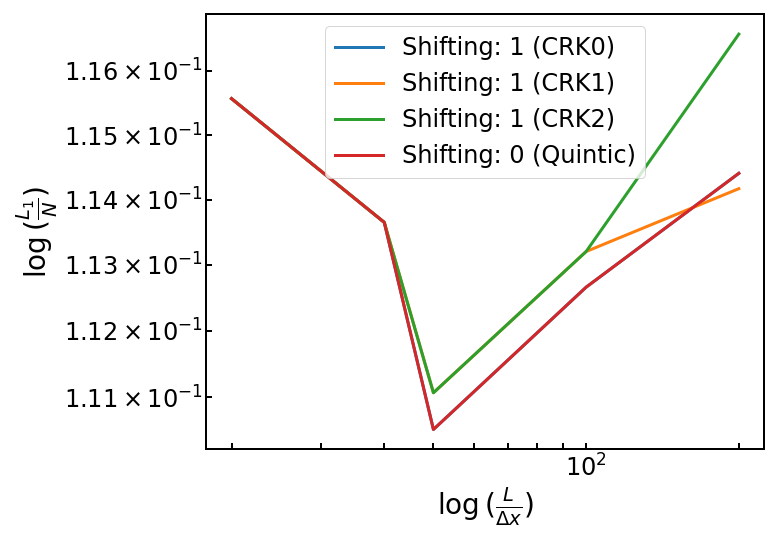

In [20]:
#---System Properties---#

d = 2 #System dimensions
r = 5 #drop radius
h3 = 3.5 #Smoothing length coefficient

eta = 0.01 #dynamic viscosity
rho_0 = 1 #initial density
nu = eta/rho_0 #kinetic viscosity

filepath = '/home/epalermo/dev/test/kernel_convergence/normal_convergence/circle_surface/data_files_old'
benchmark(generate_file_names(filepath),"circle")

#CRK0 overlaps with CRK1

   Shifting CRK  Resolution     Error
17        0   0        20.0  0.115567
4         0   0        40.0  0.113652
2         0   0        50.0  0.110517
9         0   0       100.0  0.112662
0         0   0       200.0  0.114407
   Shifting CRK  Resolution     Error
12        0   1        20.0  0.115567
14        0   1        40.0  0.113652
16        0   1        50.0  0.111066
10        0   1       100.0  0.113205
1         0   1       200.0  0.114170
   Shifting CRK  Resolution     Error
19        0   5        20.0  0.115567
13        0   5        40.0  0.113652
11        0   5        50.0  0.110517
3         0   5       100.0  0.112662
8         0   5       200.0  0.114407
   Shifting CRK  Resolution     Error
18        0   2        20.0  0.115567
6         0   2        40.0  0.113652
15        0   2        50.0  0.111066
7         0   2       100.0  0.113205
5         0   2       200.0  0.114170


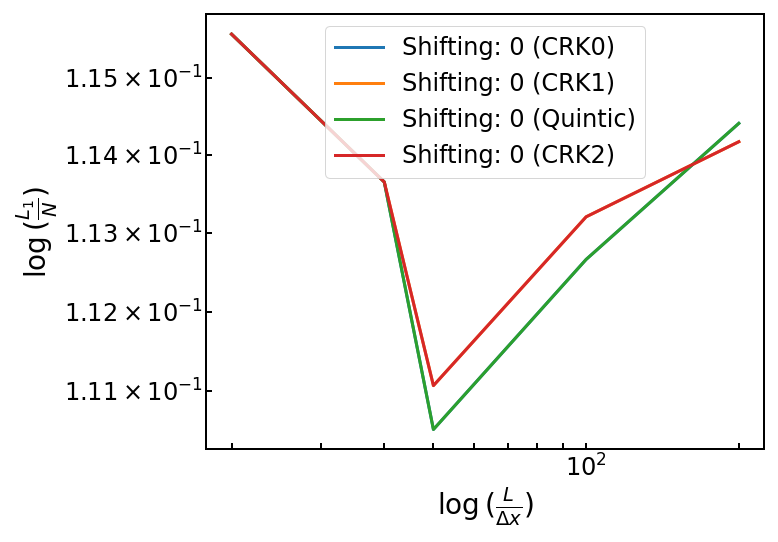

In [21]:
#---System Properties---#

d = 2 #System dimensions
r = 5 #drop radius
h3 = 3.5 #Smoothing length coefficient

eta = 0.01 #dynamic viscosity
rho_0 = 1 #initial density
nu = eta/rho_0 #kinetic viscosity

filepath = '/home/epalermo/dev/test/kernel_convergence/normal_convergence/circle_surface/data_files/'
benchmark(generate_file_names(filepath),"circle")

#CRK0 overlaps with CRK1